# Investigation Precipitation and Temperature Anomalies

* This script investigates the precipitation and temperature data
* Precipitation and temperature data are uploaded to github repository

* This is modelled after Lesson 10 Time Series
* Dr. Silverstein helped to debug the code for cleaning up the data and outputting the anomaly values. Learned: important to check the data type of the information that is being inputted and outputted of the cell

In [1]:
# import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

import geopandas as gpd
from shapely.geometry import Point, Polygon

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

## Precipitation Anomalies

In [2]:
# import data
# source: https://data.gov.in/catalog/rainfall-india?filters%5Bfield_catalog_reference%5D=1090541&format=json&offset=0&limit=6&sort%5Bcreated%5D=desc
import os
os.chdir(r'C:\\Users\\livsh\\Downloads') 
precip = pd.read_csv('monthly precipitation.csv')

**Data Background**
The temperature data is in the form of temperature anomalies (differences from the mean/average value) per month and per season (DJF=Dec-Feb, MAM=Mar-May, etc). We won't be working with absolute temperature data since anomalies are more important than absolute temperature in climate change investigations. A positive anomaly value means that the observed precipitation was greater than the baseline average and a negative anomaly value means that it was less than the baseline average.

In [3]:
precip = precip[(precip['SUBDIVISION']  == 'East Rajasthan')]
len(precip)

117

In [4]:
precip.head()

SUBDIVISION  YEAR   JAN  FEB   MAR  APR   MAY   JUN    JUL    AUG  \
1966  East Rajasthan  1901  21.6  8.9   2.9  0.7   5.0  15.0  164.8  175.6   
1967  East Rajasthan  1902   4.1  0.7   0.0  1.8   9.9  34.6  247.6  116.7   
1968  East Rajasthan  1903   1.9  0.7   1.3  0.1  12.9  15.6  238.2  229.1   
1969  East Rajasthan  1904   4.3  5.5  21.7  0.2  27.5  49.9  289.7  223.5   
1970  East Rajasthan  1905   4.1  8.8   3.2  1.6   2.0  14.4  130.5   30.9   

        SEP   OCT  NOV   DEC  ANNUAL    JF   MAM   JJAS   OND  
1966    7.5   9.8  0.0   0.8   412.5  30.5   8.5  362.9  10.6  
1967  145.6  14.4  0.0   2.8   578.3   4.8  11.7  544.5  17.2  
1968  168.5  17.8  0.0   0.0   686.1   2.7  14.2  651.4  17.8  
1969   50.2   1.5  5.8  14.7   694.5   9.8  49.4  613.3  22.0  
1970   83.8   0.0  0.0   0.6   279.8  12.8   6.8  259.6   0.6

In [5]:
# reset index so it is easier to keep track of years/ index
precip = precip.dropna(axis=0, how = 'any') 
#precip.reset_index(inplace = True)
#instructor code
precip.reset_index(inplace = True, drop = True)


print(len(precip))
precip.head()

117


SUBDIVISION  YEAR   JAN  FEB   MAR  APR   MAY   JUN    JUL    AUG  \
0  East Rajasthan  1901  21.6  8.9   2.9  0.7   5.0  15.0  164.8  175.6   
1  East Rajasthan  1902   4.1  0.7   0.0  1.8   9.9  34.6  247.6  116.7   
2  East Rajasthan  1903   1.9  0.7   1.3  0.1  12.9  15.6  238.2  229.1   
3  East Rajasthan  1904   4.3  5.5  21.7  0.2  27.5  49.9  289.7  223.5   
4  East Rajasthan  1905   4.1  8.8   3.2  1.6   2.0  14.4  130.5   30.9   

     SEP   OCT  NOV   DEC  ANNUAL    JF   MAM   JJAS   OND  
0    7.5   9.8  0.0   0.8   412.5  30.5   8.5  362.9  10.6  
1  145.6  14.4  0.0   2.8   578.3   4.8  11.7  544.5  17.2  
2  168.5  17.8  0.0   0.0   686.1   2.7  14.2  651.4  17.8  
3   50.2   1.5  5.8  14.7   694.5   9.8  49.4  613.3  22.0  
4   83.8   0.0  0.0   0.6   279.8  12.8   6.8  259.6   0.6

In [6]:
precip.isna().sum() 
# all 0's for each column - so no data is missing

SUBDIVISION    0
YEAR           0
JAN            0
FEB            0
MAR            0
APR            0
MAY            0
JUN            0
JUL            0
AUG            0
SEP            0
OCT            0
NOV            0
DEC            0
ANNUAL         0
JF             0
MAM            0
JJAS           0
OND            0
dtype: int64

In [7]:
describe = precip.describe()
describe

YEAR         JAN         FEB         MAR         APR  \
count   117.000000  117.000000  117.000000  117.000000  117.000000   
mean   1959.000000    6.389744    5.328205    4.518803    3.096581   
std      33.919021    8.172530    7.436592    9.067353    5.898582   
min    1901.000000    0.000000    0.000000    0.000000    0.000000   
25%    1930.000000    0.700000    0.400000    0.200000    0.200000   
50%    1959.000000    3.600000    2.200000    1.400000    1.000000   
75%    1988.000000    8.600000    8.500000    4.100000    3.100000   
max    2017.000000   39.200000   35.700000   57.400000   43.200000   

              MAY         JUN         JUL         AUG         SEP         OCT  \
count  117.000000  117.000000  117.000000  117.000000  117.000000  117.000000   
mean     9.862393   63.611111  224.824786  219.015385   97.043590   14.394017   
std     12.160236   42.703270   84.291405   95.187826   70.360389   24.904764   
min      0.000000    5.100000   13.500000   30.900000    3.300000    0.000000   
25%      2.600000   30.800000  164.800000  142.800000   40.400000    0.600000   
50%      5.700000   53.400000  227.800000  223.100000   88.000000    4.700000   
75%     12.700000   89.900000  288.800000  283.700000  131.300000   14.400000   
max     90.900000  209.100000  440.600000  435.800000  337.200000  161.900000   

              NOV         DEC       ANNUAL          JF         MAM  \
count  117.000000  117.000000   117.000000  117.000000  117.000000   
mean     4.794017    3.617949   656.501709   11.715385   17.484615   
std     10.547326    6.700625   166.163458   11.307989   16.819886   
min      0.000000    0.000000   273.600000    0.000000    0.200000   
25%      0.000000    0.100000   551.800000    2.800000    7.800000   
50%      0.400000    0.700000   655.400000    8.800000   12.200000   
75%      3.700000    3.900000   759.900000   17.500000   21.300000   
max     58.100000   37.700000  1350.400000   51.100000  105.900000   

              JJAS         OND  
count   117.000000  117.000000  
mean    604.490598   22.807692  
std     156.559274   27.230530  
min     242.000000    0.000000  
25%     505.700000    4.200000  
50%     611.300000   13.500000  
75%     701.300000   29.900000  
max    1132.000000  168.000000

In [8]:
describe.iloc[[1], [1]]

JAN
mean  6.389744

### DataTime Index
* Create empty dataframe with a DateTime index of monthly frequency and then populate this dataframe using the raw data
* Empty dataframe range from January 1901 to December 2017

In [9]:
# Make a new dataframe with an index for each month
# first create the date range
date_rng = pd.date_range(start='1/1/1901', end='1/1/2018', freq='M')

type(date_rng[0])
### returns 
### pandas._libs.tslibs.timestamps.Timestamp

# then, create the empty DataFrame, which we will populate using the raw data
p = pd.DataFrame(date_rng, columns=['date'])

# Create a column for the anomoly values
p['Avg_Anomaly_mm'] = None

# Set the index of the DataFrame to the date column (DateTime index)
p.set_index('date', inplace=True)

# Show the first few elements
p.head()

# using the last day of each month for the indexes bc we only care about the month

Avg_Anomaly_mm
date                     
1901-01-31           None
1901-02-28           None
1901-03-31           None
1901-04-30           None
1901-05-31           None

### Time series manipulation and dealing with missing values

In [10]:
# select only the data that we want - which is the year column and the month columns, leaving out the season columns
#precip = precip.iloc[:, 2:15]

#instructor code
precip = precip.iloc[:, 1:14]


precip.head()

#instructor code
print(precip.dtypes)
precip['YEAR'] = precip['YEAR'].astype(int)


precip.rename(columns = {'YEAR':'Year', 'JAN':'Jan',
                         'FEB':'Feb', 'MAR':'Mar',
                         'APR':'Apr', 'MAY':'May','JUN':'Jun',
                         'JUL':'Jul', 'AUG':'Aug','SEP':'Sep',
                         'OCT':'Oct', 'NOV':'Nov','DEC':'Dec'}, inplace = True)
print(precip.dtypes)  # want to check the data types
precip.head()

YEAR      int64
JAN     float64
FEB     float64
MAR     float64
APR     float64
MAY     float64
JUN     float64
JUL     float64
AUG     float64
SEP     float64
OCT     float64
NOV     float64
DEC     float64
dtype: object
Year      int32
Jan     float64
Feb     float64
Mar     float64
Apr     float64
May     float64
Jun     float64
Jul     float64
Aug     float64
Sep     float64
Oct     float64
Nov     float64
Dec     float64
dtype: object


Year   Jan  Feb   Mar  Apr   May   Jun    Jul    Aug    Sep   Oct  Nov  \
0  1901  21.6  8.9   2.9  0.7   5.0  15.0  164.8  175.6    7.5   9.8  0.0   
1  1902   4.1  0.7   0.0  1.8   9.9  34.6  247.6  116.7  145.6  14.4  0.0   
2  1903   1.9  0.7   1.3  0.1  12.9  15.6  238.2  229.1  168.5  17.8  0.0   
3  1904   4.3  5.5  21.7  0.2  27.5  49.9  289.7  223.5   50.2   1.5  5.8   
4  1905   4.1  8.8   3.2  1.6   2.0  14.4  130.5   30.9   83.8   0.0  0.0   

    Dec  
0   0.8  
1   2.8  
2   0.0  
3  14.7  
4   0.6

In [11]:
# apply Panda's function to move through the rows of the raw data (axis =0 for columns, 1 for rows)
# also need to important the datetime and calendar libraries that we are going to use


# Import needed libraries
import calendar
from datetime import datetime

# define function 
def pop_df_with_anomolies_from_row(row):
    year = row['Year'].astype(int) # instructor update
    # anomaly values (appear to be mixture of strings + floats)
    monthly_anomolies = row.iloc[1:]
    # abbreviated month names (index names)
    months = monthly_anomolies.index
    for month in monthly_anomolies.index:
        # get the last day for each month 
        last_day = calendar.monthrange(year,datetime.strptime(month, '%b').month)[1]
        # construct the index with which we can reference our new DataFrame (to populate) 
        date_index = datetime.strptime(f'{year} {month} {last_day}', '%Y %b %d')
        # populate / set value @ above index, to anomaly value
        p.loc[date_index] = monthly_anomolies[month]

# apply function to each row of raw data 
_ = precip.apply(lambda row: pop_df_with_anomolies_from_row(row), axis=1)

# Show the first few elements of our newly populated DataFrame
print(p)

# instructor edits
p['Avg_Anomaly_mm'] = p['Avg_Anomaly_mm'].astype(float)
print(p.dtypes)

           Avg_Anomaly_mm
date                     
1901-01-31           21.6
1901-02-28            8.9
1901-03-31            2.9
1901-04-30            0.7
1901-05-31              5
...                   ...
2017-08-31          137.3
2017-09-30           46.4
2017-10-31              0
2017-11-30            0.4
2017-12-31            3.4

[1404 rows x 1 columns]
Avg_Anomaly_mm    float64
dtype: object


In [12]:
# no need to clean anonmaly values since there were no NaN

### Plot the time series

C:\Users\livsh\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


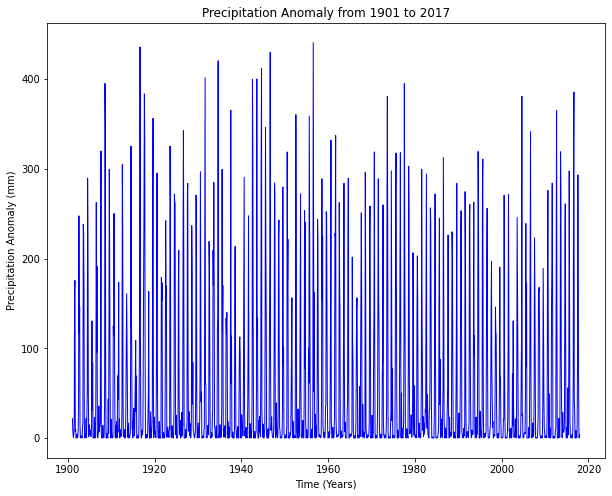

In [13]:
# Plot the data

# import Matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

# create figure, title and plot data
plt.figure(figsize=(10,8))
plt.xlabel('Time (Years)')
plt.ylabel('Precipitation Anomaly (mm)')
plt.title('Precipitation Anomaly from 1901 to 2017')
plt.plot(p, color='blue', linewidth=1.0);

* As we move forward in time, it seems as it the peaks (maximums) are decreasing. This is concurrent with the information from the locals where the project will be
* Above is granualar data. There is a lot of variation and fluctuation and it is difficult to determine the trends from year to year and month to month

### Resampling at a different frequency
* The plot above seems messy in a sense that it covers such a logn time span with data that is quite granualar
* The visualization includes a lot of variation
* Change the frequency from months to years

In [14]:
p.resample('A').mean().head()   
# trying to remove fluctuations
# takign the average value (mean)
# A represents the year calendar end

Avg_Anomaly_mm
date                      
1901-12-31       34.383333
1902-12-31       48.183333
1903-12-31       57.175000
1904-12-31       57.875000
1905-12-31       23.325000

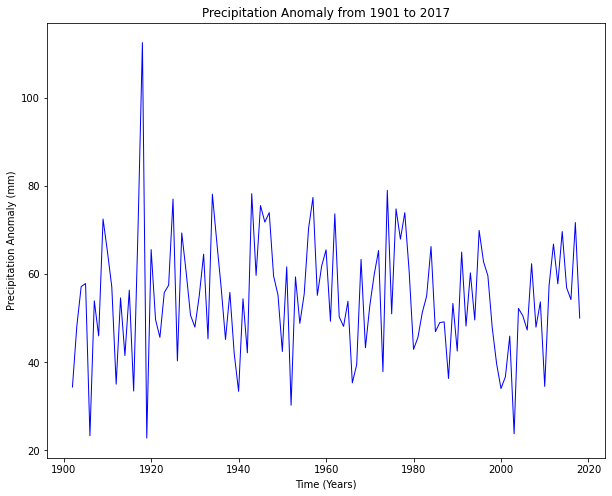

In [15]:
# Visualize the resampled DataFrame

# Create figure, title and plot resampled data
plt.figure(figsize=(10,8))
plt.xlabel('Time (Years)')
plt.ylabel('Precipitation Anomaly (mm)')
plt.title('Precipitation Anomaly from 1901 to 2017')
plt.plot(p.resample('A').mean(), color='blue', linewidth=1.0);

* This plot above seems much more clear than the previous graph. The resampling makes it easier to determine and vizualize the anamoly precipitation trends

## Temperature Anomalies
* this section will investigate temperature anomalies and create similar visualizations that were created for precipitation anomalies

In [16]:
# import temperature data
# source: https://data.gov.in/resources/monthly-seasonal-and-annual-mean-temp-series-1901-2017
# uploaded temperature data to github

import os
os.chdir(r'C:\\Users\\livsh\\Downloads') 
temp = pd.read_csv('temperature.csv')

In [17]:
temp.head().T

0        1        2        3        4
YEAR    1901.00  1902.00  1903.00  1904.00  1905.00
JAN       17.99    19.00    18.32    17.77    17.40
FEB       19.43    20.39    19.79    19.39    17.79
MAR       23.49    24.10    22.46    22.95    21.78
APR       26.41    26.54    26.03    26.73    24.84
MAY       28.28    28.68    27.93    27.83    28.32
JUN       28.60    28.44    28.41    27.85    28.69
JUL       27.49    27.29    28.04    26.84    27.67
AUG       26.98    27.05    26.63    26.73    27.47
SEP       26.26    25.95    26.34    25.84    26.29
OCT       25.08    24.37    24.57    24.36    26.16
NOV       21.73    21.33    20.96    21.07    22.07
DEC       18.95    18.78    18.29    18.84    18.71
ANNUAL    24.23    24.33    23.80    23.86    23.71
JF        18.71    19.70    19.05    18.66    17.58
MAM       26.06    26.44    25.47    25.84    24.99
JS        27.30    27.18    27.17    26.83    27.37
OND       21.92    21.49    21.27    21.42    21.48

In [18]:
temp = temp.dropna(axis=0, how = 'any') 
temp.reset_index(inplace = True, drop = True)
print(len(temp))  # check length of dataframe
temp.head()

116


YEAR    JAN    FEB    MAR    APR    MAY    JUN    JUL    AUG    SEP    OCT  \
0  1901  17.99  19.43  23.49  26.41  28.28  28.60  27.49  26.98  26.26  25.08   
1  1902  19.00  20.39  24.10  26.54  28.68  28.44  27.29  27.05  25.95  24.37   
2  1903  18.32  19.79  22.46  26.03  27.93  28.41  28.04  26.63  26.34  24.57   
3  1904  17.77  19.39  22.95  26.73  27.83  27.85  26.84  26.73  25.84  24.36   
4  1905  17.40  17.79  21.78  24.84  28.32  28.69  27.67  27.47  26.29  26.16   

     NOV    DEC  ANNUAL     JF    MAM     JS    OND  
0  21.73  18.95   24.23  18.71  26.06  27.30  21.92  
1  21.33  18.78   24.33  19.70  26.44  27.18  21.49  
2  20.96  18.29   23.80  19.05  25.47  27.17  21.27  
3  21.07  18.84   23.86  18.66  25.84  26.83  21.42  
4  22.07  18.71   23.71  17.58  24.99  27.37  21.48

In [19]:
temp.isna().sum() 
# all 0's for each column - so no data is missing

YEAR      0
JAN       0
FEB       0
MAR       0
APR       0
MAY       0
JUN       0
JUL       0
AUG       0
SEP       0
OCT       0
NOV       0
DEC       0
ANNUAL    0
JF        0
MAM       0
JS        0
OND       0
dtype: int64

In [20]:
describe = temp.describe().T
describe

count         mean        std      min        25%       50%  \
YEAR    116.0  1958.500000  33.630343  1901.00  1929.7500  1958.500   
JAN     116.0    18.404569   0.581218    17.25    18.0675    18.340   
FEB     116.0    20.112586   0.861884    17.79    19.4700    19.985   
MAR     116.0    23.415690   0.842945    21.78    22.8325    23.320   
APR     116.0    26.491207   0.711790    24.84    25.9900    26.535   
MAY     116.0    28.368448   0.617371    26.97    27.9475    28.335   
JUN     116.0    28.291121   0.450134    27.33    28.0175    28.250   
JUL     116.0    27.361121   0.336064    26.48    27.1500    27.340   
AUG     116.0    26.929914   0.332510    26.21    26.7275    26.895   
SEP     116.0    26.327414   0.352551    25.47    26.1075    26.310   
OCT     116.0    24.720517   0.514948    23.52    24.3850    24.665   
NOV     116.0    21.747155   0.604138    20.59    21.3175    21.715   
DEC     116.0    19.153534   0.601364    17.98    18.7750    19.165   
ANNUAL  116.0    24.261379   0.396366    23.56    24.0000    24.150   
JF      116.0    19.236810   0.630786    17.58    18.8450    19.115   
MAM     116.0    26.067328   0.572031    24.89    25.6775    26.030   
JS      116.0    27.222414   0.294390    26.53    27.0600    27.180   
OND     116.0    21.860086   0.507280    20.96    21.4800    21.815   

              75%      max  
YEAR    1987.2500  2016.00  
JAN       18.7200    20.92  
FEB       20.5425    23.58  
MAR       23.9150    26.61  
APR       26.9025    29.56  
MAY       28.7525    30.78  
JUN       28.5650    29.88  
JUL       27.5150    28.47  
AUG       27.1425    28.17  
SEP       26.4850    27.72  
OCT       24.9200    26.81  
NOV       22.1425    23.90  
DEC       19.5350    21.89  
ANNUAL    24.4525    26.45  
JF        19.5875    22.25  
MAM       26.4125    28.86  
JS        27.3400    28.44  
OND       22.1400    24.20

In [21]:
# Make a new dataframe with an index for each month
# first create the date range
date_rng = pd.date_range(start='1/1/1880', end='1/7/2019', freq='M')

type(date_rng[0])
### returns 
### pandas._libs.tslibs.timestamps.Timestamp

# then, create the empty DataFrame, which we will populate using the raw data
t = pd.DataFrame(date_rng, columns=['date'])

# Create a column for the anomoly values
t['Avg_Anomaly_deg_C'] = None

# Set the index of the DataFrame to the date column (DateTime index)
t.set_index('date', inplace=True)

# Show the first few elements
t.head()

# using the last day of each month for the indexes bc we only care about the month

Avg_Anomaly_deg_C
date                        
1880-01-31              None
1880-02-29              None
1880-03-31              None
1880-04-30              None
1880-05-31              None

In [22]:
# select only the data that we want - which is the year column and the month columns, leaving out the season columns
#precip = precip.iloc[:, 2:15]

#instructor code
temp = temp.iloc[:, :13]


temp.head()

#instructor code
print(temp.dtypes)
temp['YEAR'] = temp['YEAR'].astype(int)


temp.rename(columns = {'YEAR':'Year', 'JAN':'Jan',
                         'FEB':'Feb', 'MAR':'Mar',
                         'APR':'Apr', 'MAY':'May','JUN':'Jun',
                         'JUL':'Jul', 'AUG':'Aug','SEP':'Sep',
                         'OCT':'Oct', 'NOV':'Nov','DEC':'Dec'}, inplace = True)
print(temp.dtypes)
temp.head()

YEAR      int64
JAN     float64
FEB     float64
MAR     float64
APR     float64
MAY     float64
JUN     float64
JUL     float64
AUG     float64
SEP     float64
OCT     float64
NOV     float64
DEC     float64
dtype: object
Year      int32
Jan     float64
Feb     float64
Mar     float64
Apr     float64
May     float64
Jun     float64
Jul     float64
Aug     float64
Sep     float64
Oct     float64
Nov     float64
Dec     float64
dtype: object


Year    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct  \
0  1901  17.99  19.43  23.49  26.41  28.28  28.60  27.49  26.98  26.26  25.08   
1  1902  19.00  20.39  24.10  26.54  28.68  28.44  27.29  27.05  25.95  24.37   
2  1903  18.32  19.79  22.46  26.03  27.93  28.41  28.04  26.63  26.34  24.57   
3  1904  17.77  19.39  22.95  26.73  27.83  27.85  26.84  26.73  25.84  24.36   
4  1905  17.40  17.79  21.78  24.84  28.32  28.69  27.67  27.47  26.29  26.16   

     Nov    Dec  
0  21.73  18.95  
1  21.33  18.78  
2  20.96  18.29  
3  21.07  18.84  
4  22.07  18.71

In [23]:
# Import needed libraries
import calendar
from datetime import datetime

# define function 
def pop_df_with_anomolies_from_row(row):
    year = row['Year'].astype(int)
    # anomaly values (appear to be mixture of strings + floats)
    monthly_anomolies = row.iloc[1:]
    # abbreviated month names (index names)
    months = monthly_anomolies.index
    for month in monthly_anomolies.index:
        # get the last day for each month 
        last_day = calendar.monthrange(year,datetime.strptime(month, '%b').month)[1]
        # construct the index with which we can reference our new DataFrame (to populate) 
        date_index = datetime.strptime(f'{year} {month} {last_day}', '%Y %b %d')
        # populate / set value @ above index, to anomaly value
        t.loc[date_index] = monthly_anomolies[month]

# apply function to each row of raw data 
_ = temp.apply(lambda row: pop_df_with_anomolies_from_row(row), axis=1)

# Show the first few elements of our newly populated DataFrame
print(t)

t['Avg_Anomaly_deg_C'] = t['Avg_Anomaly_deg_C'].astype(float)
print(t.dtypes)

           Avg_Anomaly_deg_C
date                        
1880-01-31              None
1880-02-29              None
1880-03-31              None
1880-04-30              None
1880-05-31              None
...                      ...
2018-08-31              None
2018-09-30              None
2018-10-31              None
2018-11-30              None
2018-12-31              None

[1668 rows x 1 columns]
Avg_Anomaly_deg_C    float64
dtype: object


In [24]:
# no need for cleaning up the data since there are no NaN values

#### Plot the data

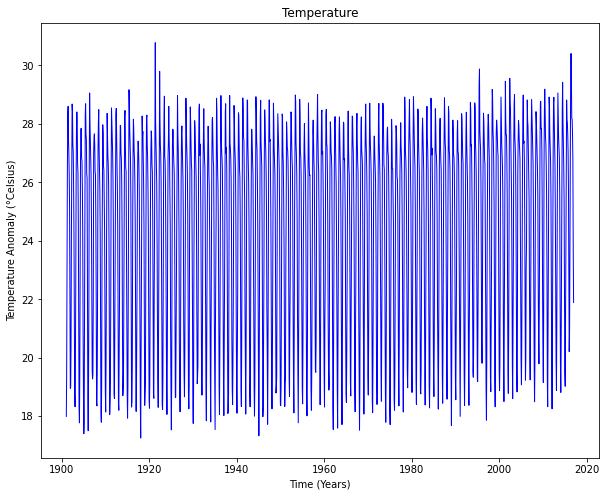

In [25]:
# create figure, title and plot data
plt.figure(figsize=(10,8))
plt.xlabel('Time (Years)')
plt.ylabel('Temperature Anomaly (°Celsius)')
plt.title('Temperature')
plt.plot(t, color='blue', linewidth=1.0);

* This graph is very granular and difficult to determine the trends from year to year
* would be helpful to resample at annual frequency instead

### Resampling at a different frequency

In [26]:
t.resample('A').mean().head()   
# trying to remove fluctuations
# takign the average value (mean)
# A represents the year calendar end

Avg_Anomaly_deg_C
date                         
1880-12-31                NaN
1881-12-31                NaN
1882-12-31                NaN
1883-12-31                NaN
1884-12-31                NaN

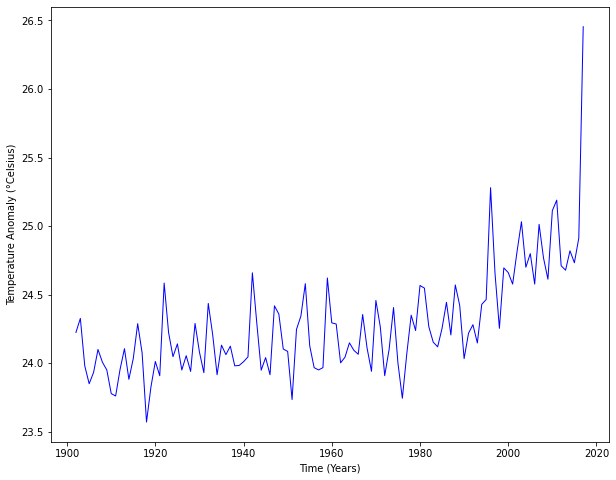

In [27]:
# Visualize our resampled DataFrame

# Create figure, title and plot resampled data
plt.figure(figsize=(10,8))
plt.xlabel('Time (Years)')
plt.ylabel('Temperature Anomaly (°Celsius)')
plt.plot(t.resample('A').mean(), color='blue', linewidth=1.0)

## Viszualizing
* since the datasets have been formated, can now plot them 
* will used two libraries to plot the data: Matplotlib and Plotly


### Plotting with Matplotlib

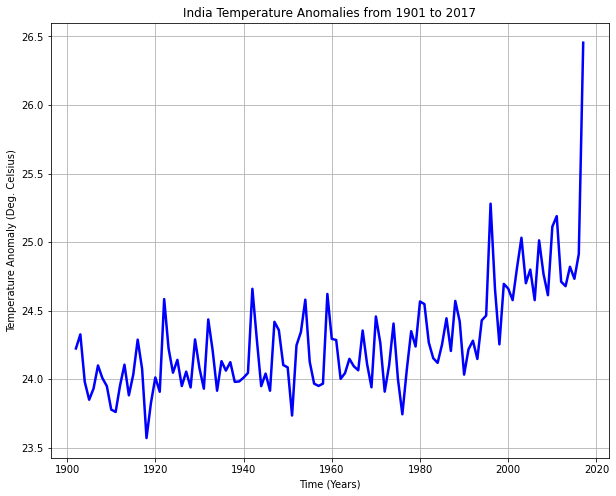

In [28]:
# graph for temperature

# Resample for temperature data to years (end-of-year)
t_resampled = t.resample('A').mean()

# Create figures and axes
fig, ax = plt.subplots(figsize=(10,8))

# Plot temperature data with specific colour and line thickness
ax.plot(t_resampled, color='blue', linewidth=2.5)

# Set axis labels and graph title
ax.set(xlabel='Time (Years)', ylabel='Temperature Anomaly (Deg. Celsius)',
       title='India Temperature Anomalies from 1901 to 2017')

# set grid
ax.grid()

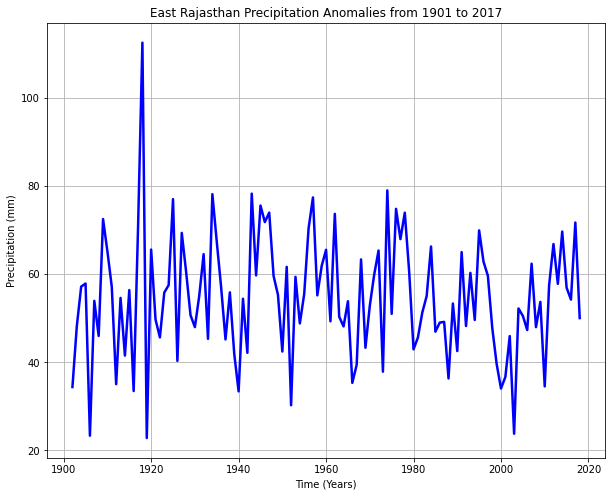

In [29]:
# graph for precipitation
# Resample for precipitation data to years (end-of-year)

p_resampled = p.resample('A').mean()

# Create figures and axes
fig, ax = plt.subplots(figsize=(10,8))

# Plot co2 emissions data with specific colour and line thickness
ax.plot(p_resampled, color='blue', linewidth=2.5)

# Set axis labels and graph title
ax.set(xlabel='Time (Years)', ylabel='Precipitation (mm)',
       title='East Rajasthan Precipitation Anomalies from 1901 to 2017')

# Enable grid
ax.grid()

### Plotting with Plotly
* more visualization of the precipitation and temperature anomalies

In [30]:
# install plotly https://anaconda.org/plotly/plotly
# Standard plotly imports
import plotly.graph_objects as go
from plotly.offline import plot, iplot

In [31]:
# using plotly and cufflinks for create more visualizations --> no importing for cufflinks
# trace for line plot of temp anomalies

trace1 = go.Scatter(
                    x = t_resampled.index,
                    y = t_resampled.Avg_Anomaly_deg_C,
                    mode = "lines",
                    marker = dict(color = 'blue'))

data = [trace1]
layout = dict(title = 'India Temperature Anomalies from 1901 to 2017',
              xaxis= dict(title= 'Time (Years)',ticklen= 5,zeroline= False),
              yaxis=dict(title = 'Temperature Anomaly (Deg. Celsius)')
             )
fig = dict(data = data, layout = layout)
iplot(fig)

# have temp anomoly and the month and year

In [32]:
# trace for line plot of precipitation
trace2 = go.Scatter(
                    x = p_resampled.index,
                    y = p_resampled.Avg_Anomaly_mm,
                    mode = "lines",
                    marker = dict(color = 'blue'))

data = [trace2]
layout = dict(title = 'East Rajasthan Precipitation Anomalies from 1901 to 2017',
              xaxis= dict(title= 'Time (Years)',ticklen= 5,zeroline= False),
              yaxis=dict(title = 'Precipitation (mm)')
             )
fig = dict(data = data, layout = layout)
iplot(fig)

* These plots are eas to interact with and investigate the anomalies for temperature and precipitation
* from the temperature graph, one can observe a pretty clear upward trend for temperature
* from the precipitation graph, there appears to be a downward trend for the amount of precipitation. This is consistent with the information from locals near the project

***
# Time Series Correlation
## Forcasting using Facebook's Prophet
### Creating, fitting, and plotting a model for precipitation

In [33]:
conda install -c conda-forge fbprophet

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


**Precipitation prediction with months**

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


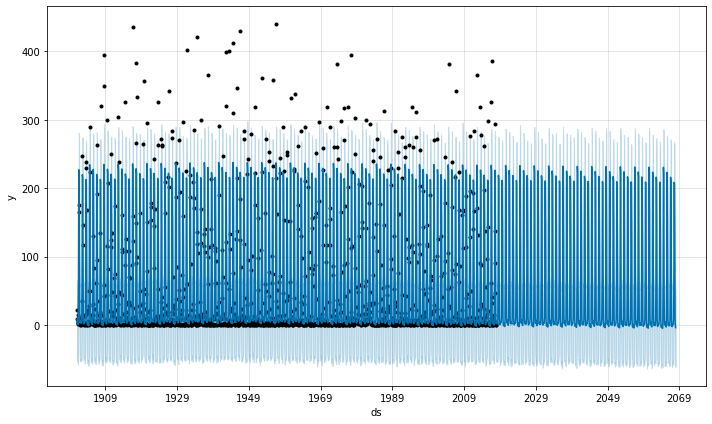

In [34]:
# import Facebook's Prophet forecasting library
from fbprophet import Prophet

# create a new DataFrame with which we will create/train our Prophet model 
p_prophet = pd.DataFrame()
p_prophet['ds'] = p.index
p_prophet['y'] = p['Avg_Anomaly_mm'].values

# instantiate model and fit to data (just like with sklearn model API)
m = Prophet()
m.fit(p_prophet)

# Future dataframe containing predictions - this is for the next 50 years
future = m.make_future_dataframe(freq='m', periods=50*12)
forecast = m.predict(future)

# plot the resulting forecast
m.plot(forecast);

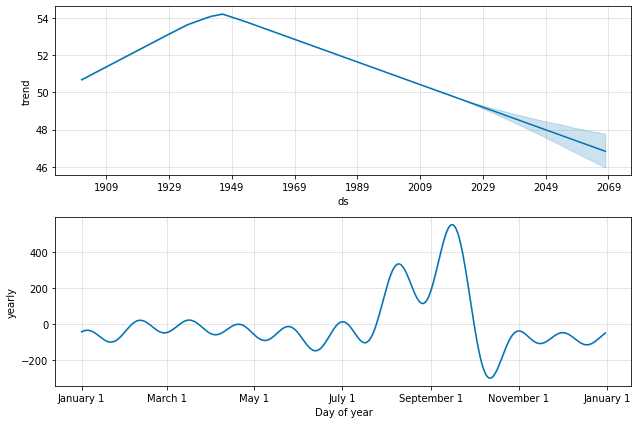

In [35]:
# Plot the forecast components
m.plot_components(forecast);

* The trend and yearly seasonality of the time series are graphed above
* There is a trend for decreasing precipitation as time goes on and for the 50 year precipitation prediction model
* For the seaonality, the cyclical nature of precipiation patterns throughout the year in India is expected. Monsoon season is typically in JJAS (June, Jule, August, and September). It is suprising that the local maximums of this plot are so great in Septemeber and into October.

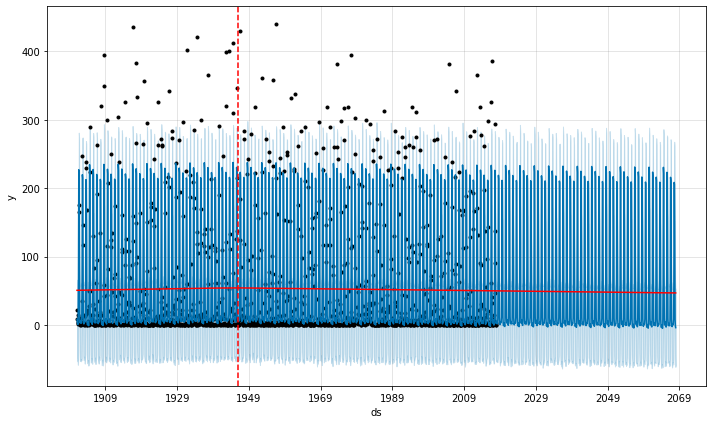

In [36]:
from fbprophet.plot import add_changepoints_to_plot

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

* Looks like a similar pattern and value of precipitation wil occur for the next 30 (thirty) years based on this model

In [37]:
# Dates where the changepoints occurred
m.changepoints

45     1904-10-31
90     1908-07-31
135    1912-04-30
180    1916-01-31
224    1919-09-30
269    1923-06-30
314    1927-03-31
359    1930-12-31
404    1934-09-30
449    1938-06-30
494    1942-03-31
539    1945-12-31
583    1949-08-31
628    1953-05-31
673    1957-02-28
718    1960-11-30
763    1964-08-31
808    1968-05-31
853    1972-02-29
898    1975-11-30
942    1979-07-31
987    1983-04-30
1032   1987-01-31
1077   1990-10-31
1122   1994-07-31
Name: ds, dtype: datetime64[ns]

In [38]:
# investigate the future dataframe
forecast.head(12)

# source: https://facebook.github.io/prophet/docs/quick_start.html
# yhat is the predicted value, there are columns for components and uncertainty intervals

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0  1901-01-31  50.675494  -48.206171   60.527717    50.675494    50.675494   
1  1901-02-28  50.682273  -53.091386   66.189081    50.682273    50.682273   
2  1901-03-31  50.689779  -51.647045   61.172721    50.689779    50.689779   
3  1901-04-30  50.697043  -58.154152   60.030993    50.697043    50.697043   
4  1901-05-31  50.704549  -49.481201   63.603174    50.704549    50.704549   
5  1901-06-30  50.711813    5.944090  121.959460    50.711813    50.711813   
6  1901-07-31  50.719319  169.205442  281.181668    50.719319    50.719319   
7  1901-08-31  50.726826  161.996303  273.986078    50.726826    50.726826   
8  1901-09-30  50.734089   30.607324  142.494690    50.734089    50.734089   
9  1901-10-31  50.741596  -40.628292   74.287588    50.741596    50.741596   
10 1901-11-30  50.748859  -52.710861   62.701004    50.748859    50.748859   
11 1901-12-31  50.756366  -52.785909   56.319061    50.756366    50.756366   

    additive_terms  additive_terms_lower  additive_terms_upper      yearly  \
0       -42.385732            -42.385732            -42.385732  -42.385732   
1       -46.909890            -46.909890            -46.909890  -46.909890   
2       -48.324967            -48.324967            -48.324967  -48.324967   
3       -50.106083            -50.106083            -50.106083  -50.106083   
4       -43.496394            -43.496394            -43.496394  -43.496394   
5        11.864924             11.864924             11.864924   11.864924   
6       176.234364            176.234364            176.234364  176.234364   
7       169.252942            169.252942            169.252942  169.252942   
8        38.480915             38.480915             38.480915   38.480915   
9       -37.497223            -37.497223            -37.497223  -37.497223   
10      -47.192325            -47.192325            -47.192325  -47.192325   
11      -47.893391            -47.893391            -47.893391  -47.893391   

    yearly_lower  yearly_upper  multiplicative_terms  \
0     -42.385732    -42.385732                   0.0   
1     -46.909890    -46.909890                   0.0   
2     -48.324967    -48.324967                   0.0   
3     -50.106083    -50.106083                   0.0   
4     -43.496394    -43.496394                   0.0   
5      11.864924     11.864924                   0.0   
6     176.234364    176.234364                   0.0   
7     169.252942    169.252942                   0.0   
8      38.480915     38.480915                   0.0   
9     -37.497223    -37.497223                   0.0   
10    -47.192325    -47.192325                   0.0   
11    -47.893391    -47.893391                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                          0.0                         0.0    8.289761  
1                          0.0                         0.0    3.772383  
2                          0.0                         0.0    2.364813  
3                          0.0                         0.0    0.590960  
4                          0.0                         0.0    7.208155  
5                          0.0                         0.0   62.576738  
6                          0.0                         0.0  226.953684  
7                          0.0                         0.0  219.979768  
8                          0.0                         0.0   89.215005  
9                          0.0                         0.0   13.244372  
10                         0.0                         0.0    3.556535  
11                         0.0                         0.0    2.862975

**Precipition predictions for annnual precipitation (using p_resampled)**

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


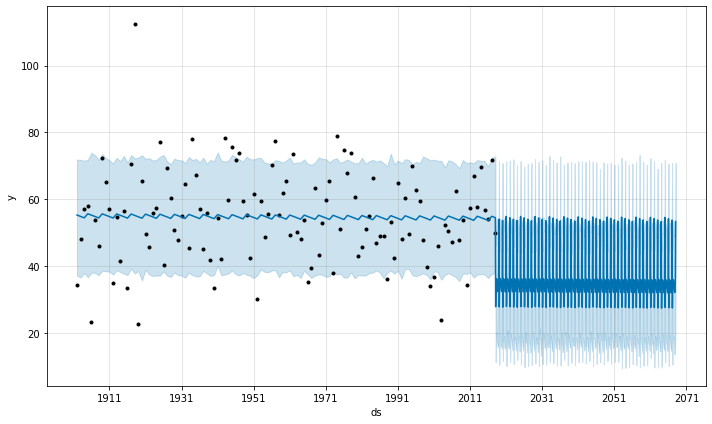

In [39]:
# import Facebook's Prophet forecasting library
from fbprophet import Prophet

# create a new DataFrame with which we will create/train our Prophet model 
p_prophet = pd.DataFrame()
p_prophet['ds'] = p_resampled.index
p_prophet['y'] = p_resampled['Avg_Anomaly_mm'].values

# instantiate model and fit to data (just like with sklearn model API)
m = Prophet()
m.fit(p_prophet)

# Future dataframe containing predictions - this is for the next 50 years
future = m.make_future_dataframe(freq='m', periods=50*12)
forecast = m.predict(future)

# plot the resulting forecast
m.plot(forecast);

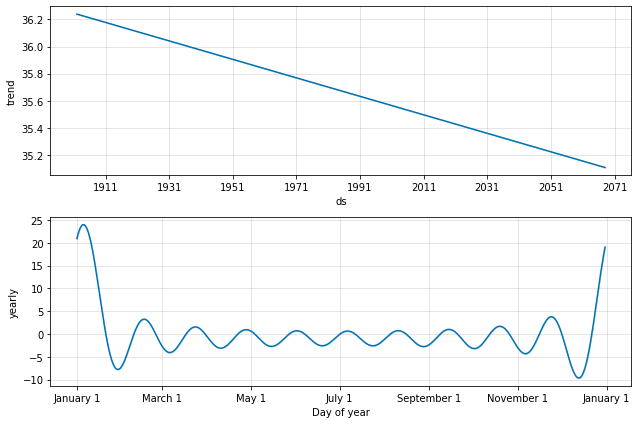

In [40]:
# Plot the forecast components
m.plot_components(forecast);

* Above is the trend adn the yearly seasonality of the time series
* As expected, there is a cyclic nature the the predicted precipitation. This graph is not as helpful for understandign the cyclical nature of precipitation throughout the year and the timing of the monsoon season

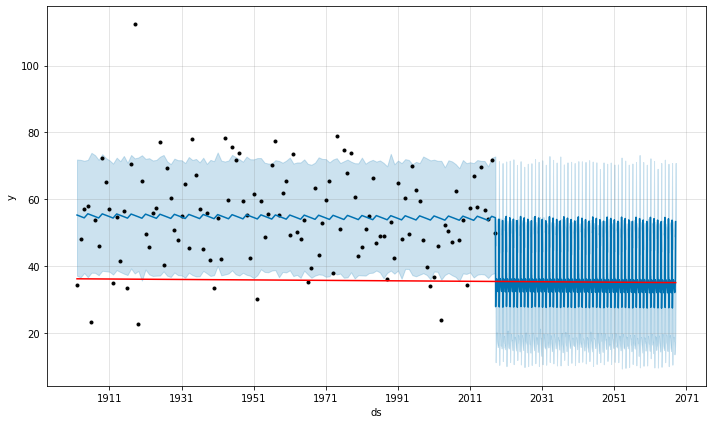

In [41]:
from fbprophet.plot import add_changepoints_to_plot

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [42]:
# Dates where the changepoints occurred
m.changepoints

4    1905-12-31
7    1908-12-31
11   1912-12-31
15   1916-12-31
18   1919-12-31
22   1923-12-31
26   1927-12-31
29   1930-12-31
33   1934-12-31
37   1938-12-31
40   1941-12-31
44   1945-12-31
48   1949-12-31
52   1953-12-31
55   1956-12-31
59   1960-12-31
63   1964-12-31
66   1967-12-31
70   1971-12-31
74   1975-12-31
77   1978-12-31
81   1982-12-31
85   1986-12-31
88   1989-12-31
92   1993-12-31
Name: ds, dtype: datetime64[ns]